In [1]:
# imports utiles
%matplotlib widget 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from pprint import pprint
import regex
import random

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

2024-02-07 14:53:43.392879: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-07 14:53:43.439326: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 14:53:43.439375: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 14:53:43.440760: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-07 14:53:43.447667: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-07 14:53:43.448124: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Lecture du jeu de données

Dans le corpus, on compte simplement la fréquence des bigrammes 'en' et 'th'

In [2]:
def load_french_data():
    fr_data = []
    with open("fr_corpus.txt") as f:
        text = f.read()
        text = regex.split(r'(?<!M)\.', text)
        # print(len(text))
        for line in text:
        
            n_es = line.count("es")
            n_ch = line.count("ch")
            l = len(line)
            if l != 0:
               # instance = {"label":label, "th": n_th / l, "en": n_en /l}
                instance = {"label":"fr", "es": n_es / l, "ch": n_ch / l}
                fr_data.append(instance)
    
    return fr_data

In [3]:
fr_data = load_french_data()
print(len(fr_data))
# pprint(fr_data[:20])

18675


In [4]:
def load_data():
    data = []
    with open("corpus.txt") as file:
        for line in file:
            label, text = line.strip().split(" ",1)
            
            # n_th = text.count("th")
            # n_en = text.count("en")
            
            # essai d'autre bigramme
            n_es = text.count("es")
            n_ch = text.count("ch")
            l = len(text)
            # instance = {"label":label, "th": n_th / l, "en": n_en /l}
            instance = {"label":label, "es": n_es / l, "ch": n_ch / l}
            data.append(instance)
    print(f'{len(data)}')
    return data



## Concatener les donner et selectionner avec random


### Changer taille des données

In [5]:
# changer taille de corpus
mix_data = load_data()
part_data = mix_data + fr_data

# selectionner taille de données 
random.seed(42)
data = random.sample(part_data, 20000)

# print(len(data))
# pprint(data[:10])

33671


## Normalisation

une pratique courante qui facilite souvent l'apprentissage consiste à normaliser les valeurs en entrée d'un réseau.

Ci-dessous, j'utilise un z-score ([standardisation](https://en.wikipedia.org/wiki/Standard_score))

$$ z = \frac{x - \mu}{\sigma} $$

In [6]:
# Tester avec ou sans standardisation

def normalise_data(dataset):
    for k in dataset[0].keys():
        if k != 'label':
            mean = np.mean([d[k] for d in dataset])
            std = np.std([d[k] for d in dataset])
            for d in dataset:
                d[k] = (d[k]- mean) / std
                
normalise_data(data) # replacing by z-score 

In [7]:
pprint(data[:10])

[{'ch': -0.7613646070277057, 'es': 0.3833856023287892, 'label': 'fr'},
 {'ch': -0.7613646070277057, 'es': -0.34301614817722553, 'label': 'eng'},
 {'ch': -0.23849703493719587, 'es': -0.6810502517757024, 'label': 'deu'},
 {'ch': -0.7613646070277057, 'es': 0.7319306873528084, 'label': 'fr'},
 {'ch': -0.1623176535730156, 'es': -1.1666767104664724, 'label': 'deu'},
 {'ch': 1.8132869101921671, 'es': 0.10866867630397438, 'label': 'deu'},
 {'ch': -0.7613646070277057, 'es': 0.6597010580879444, 'label': 'eng'},
 {'ch': -0.7613646070277057, 'es': -1.1666767104664724, 'label': 'eng'},
 {'ch': -0.26975542239912853, 'es': -1.1666767104664724, 'label': 'fr'},
 {'ch': 0.5090860948214263, 'es': 0.24927908762627776, 'label': 'deu'}]


# Perceptron en python

la fonction de classification prend en argument l'instance $i$ à classifier et les paramètres $W$ du modèle .

 $$f(v;W) = vW$$
 $$f(v) = v[0]*W_0 + v[1]*W_1 $$

Pour faciliter la visualisation, on n'utilise pas de *biais* (on fixe $b=0$)


In [8]:
# def perceptron_str(instance, params) -> str:
#     # activation = params['th'] * instance['th'] + params['en'] * instance['en']
#     activation = params['es'] * instance['es'] + params['ch'] * instance['ch']
    
#     z = 1/(1 + np.exp(-activation))  # sigmoïde
#     return "eng" if z > 0.5 else "deu" 

In [9]:
# def perceptron_float(instance, params) -> float:
#     # activation = params['th'] * instance['th'] + params['en'] * instance['en'] # dot product
#     activation = params['es'] * instance['es'] + params['ch'] * instance['ch']
#     z = 1/(1 + np.exp(-activation))  # sigmoïde 
#     return z

# Exploration de l'espace des paramètres


### Formula MSE - MEAN SQUARED ERROR 
$$ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (\hat{y}_i - y_i)^2 $$

- n is the total number of instances 
- $\hat{y} $ is the predicted value of the  $ i^{th} $ instance
- $ y_i $ is the true value (label) for the $ i^{th} $ instance
 


In [10]:
# # génération d'une grille pour couvrir l'ensemble des paramètres possibles
# # x -> poids de EN
# # y -> poids de TH
# X = np.arange(-1, 1, .1)
# Y = np.arange(-1, 1, .1)
# X, Y = np.meshgrid(X, Y)

# dataset = data
# total = len(dataset)

# # fonction qui évalue un couple de paramètres 
# def evaluation_acc(x,y)-> float:
#     ok = 0
#     # params = {'en':x, 'th':y}
#     params = {'es':x, 'ch':y}
#     for inst in dataset:
#         if perceptron_str(inst, params) == inst['label']: # if «en» or «deu»
#             ok += 1.0
#     return ok / total  # acc 0 or 1

# # mean squared error 
# def evaluation_mse(x,y)-> float: 
#     mse = 0
#     # params = {'en':x, 'th':y}
#     params = {'es':x, 'ch':y}
#     for inst in dataset: # for each item in dataset compare values
#         r = perceptron_float(inst, params)  # returns 'eng' or 'deu'
#         gold = 1.0 if inst['label'] == 'eng' else 0.0
#         mse += (r - gold)**2 
#     return mse / total


# # On applique cette fonction à toute la grille 
# # Z = toutes les exactitudes à différents endroits de l'espace
# Z_acc = np.vectorize(evaluation_acc)(X,Y)       
# Z_mse = np.vectorize(evaluation_mse)(X,Y)       

In [11]:
# from matplotlib import cm
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.plot_surface(X,Y,Z_acc, alpha=0.8, cmap=cm.coolwarm)
# ax.set_xlabel('W EN')
# ax.set_ylabel('W TH')
# ax.set_zlabel('précision du modèle')
# plt.show()

In [12]:
# from matplotlib import cm
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.plot_surface(X,Y,Z_mse, alpha=0.8, cmap=cm.coolwarm)
# ax.set_xlabel('W EN')
# ax.set_ylabel('W TH')
# ax.set_zlabel('erreur moyenne (MSE)')
# plt.show()

# Version Keras

In [13]:
%env TF_FORCE_GPU_ALLOW_GROWTH=true
import tensorflow as tf
import keras

env: TF_FORCE_GPU_ALLOW_GROWTH=true


## Définition d'un modèle équivalent au perceptron
- en entrée des instances avec deux valeurs
- une simple couche dense
- la sigmoïde en fonction d'activation

  ### Deux façons de faire :
  (séquentielle et fonctionnelle)

In [14]:
# sequential

input_shape = (2,) 
num_classes = 3  

def PerceptronModel():
    model = keras.Sequential([
        keras.Input(shape=input_shape, name="entrée"),
        keras.layers.Dense(2, activation="softmax", name="layer1", use_bias=True), 
        keras.layers.Dense(1, activation="softmax", name="layer2", use_bias=True),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    # model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [15]:
# # functional
# def PerceptronModel():
#     inputs = keras.layers.Input(shape=(2,), name="entrée")
#     # use_bias
#     neuron = keras.layers.Dense(1, activation="sigmoid", use_bias=True, name="couche1")(inputs) # add dense layer
#     model = keras.Model(inputs=inputs, outputs=neuron)
#     # model.add 
    
#     model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=["accuracy"]) # change for multiclass
#     return model

## Préparation des données
- Pour l'entrainement, on doit transformer nos instances en **array** numpy ou (mieux) en **tenseurs**
- en séparant les données (inputs) de leurs labels (output)

In [16]:
# # training_data = np.array([[d['th'], d['en']] for d in data])

# training_data = np.array([[d['ch'], d['es']] for d in data])
# # labels = np.array([0.0 if d['label'] == 'deu' else 1.0 for d in data]) 
# # for multiclass
# label_mapping = {'deu': 0, 'eng': 1, 'fr': 2}
# labels = np.array([label_mapping[d['label']] for d in data])



In [17]:
training_data = np.array([[d['ch'], d['es']] for d in data])
# tr_reshape = np.reshape(training_data, (len(training_data), -1))
# for multiclass
# tr = ([[d['ch'], d['es']] for d in data])
label_mapping = {'deu': 0, 'eng': 1, 'fr': 2}
labels = np.array([label_mapping[d['label']] for d in data])
labels = keras.utils.to_categorical(labels, num_classes = 3)

# print(training_data[:20])
# print(labels[:20])

In [18]:
# print(num_classes)
# print(one_hot_labels.shape)
training_data.shape, labels.shape 

((20000, 2), (20000, 3))

### split en train et test

In [19]:
# split train test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(training_data, labels, test_size=0.2, random_state=42)

In [20]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(16000, 2) (16000, 3)
(4000, 2) (4000, 3)


## Création et visualisation d'un modèle

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ (None, 2)                 │          6 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ layer2 (Dense)                  │ (None, 1)                 │          3 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 3)                 │          6 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 15 (60.00 B)

 Trainable params: 15 (60.00 B)

 Non-trainable params: 0 (0.00 B)

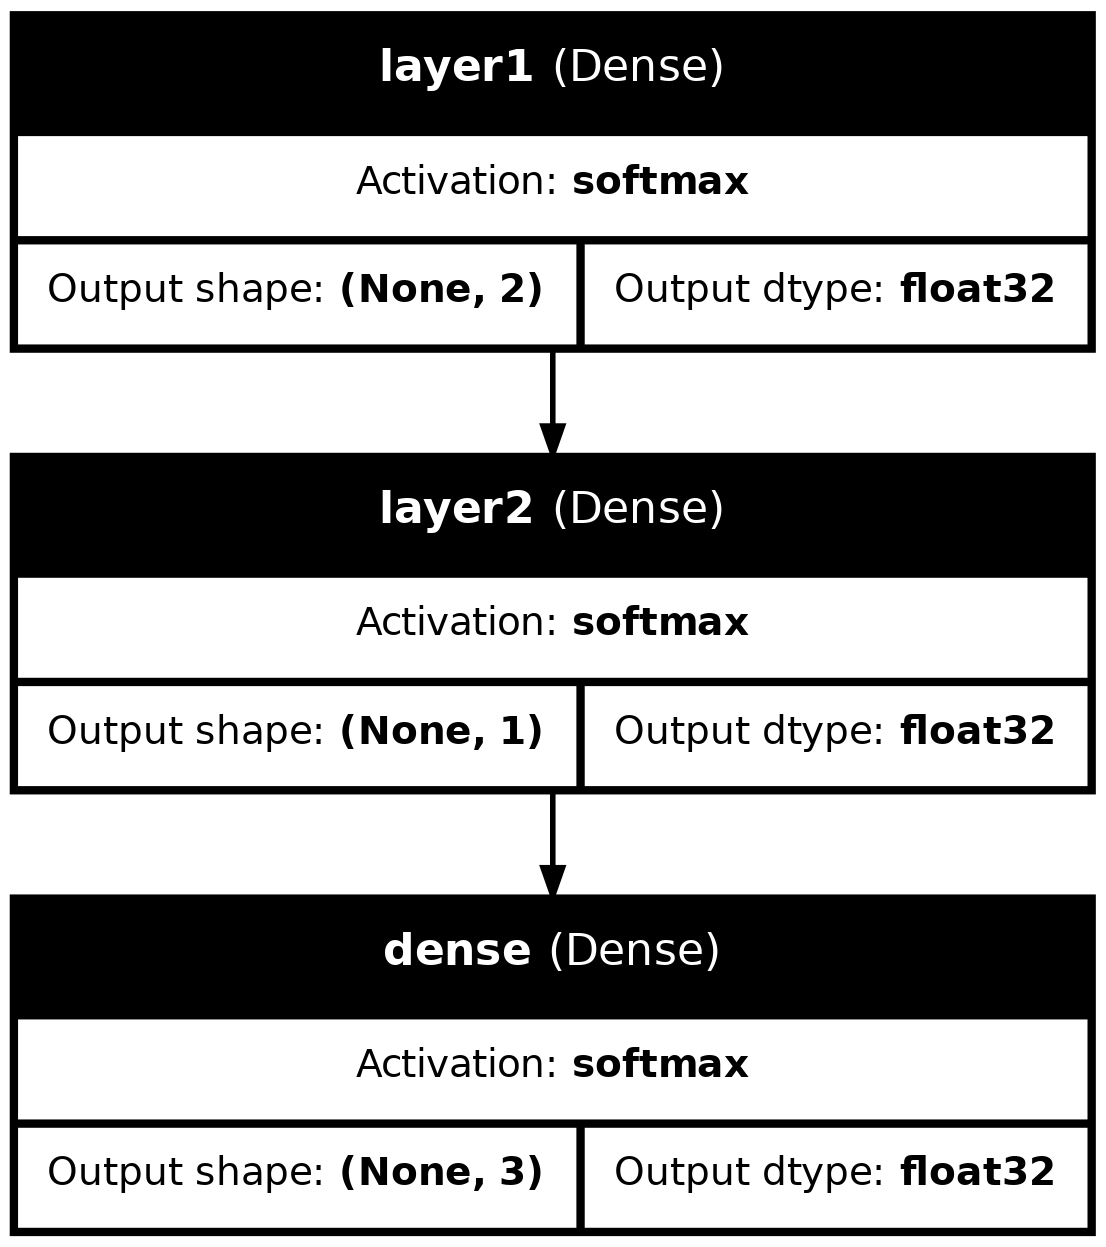

In [21]:
m = PerceptronModel()
m.summary()
keras.utils.plot_model(m,show_dtype=True, show_shapes=True, show_layer_names=True, show_layer_activations=True)

## Entraînement du modèle

(Attention: que ce passe-t-il si on relance plusieurs fois la cellulle suivante ?)

In [22]:
# m.fit(x=training_data, y=labels, epochs=10, batch_size=4, validation_split=0.2)

# Fit with train data
m.fit(x=X_train, y=y_train, epochs=30, batch_size=4, validation_split=0.2)

Epoch 1/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3238 - loss: 1.1338 - val_accuracy: 0.3569 - val_loss: 1.0979
Epoch 2/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - accuracy: 0.3594 - loss: 1.0972 - val_accuracy: 0.3569 - val_loss: 1.0971
Epoch 3/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - accuracy: 0.3532 - loss: 1.0974 - val_accuracy: 0.3569 - val_loss: 1.0974
Epoch 4/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - accuracy: 0.3454 - loss: 1.0983 - val_accuracy: 0.3569 - val_loss: 1.0973
Epoch 5/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3483 - loss: 1.0979 - val_accuracy: 0.3569 - val_loss: 1.0972
Epoch 6/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.3534 - loss: 1.0978 - val_accuracy: 0.3569 - val_loss: 1.0970
Epoch 7/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.3572 - loss: 1.0968 - val_accuracy: 0.3569 - val_loss: 1.0974
Epoch 8/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.3558 - loss: 1.0975 - val_

### Evaluation avec Test

In [23]:
# Evaluation 
score = m.evaluate(X_test, y_test, verbose=0) # score = test_loss, test_accuracy
print(f'{score[0]}  |  {score[1]} ')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1.0963082313537598  |  0.3644999861717224 
Test loss: 1.0963082313537598
Test accuracy: 0.3644999861717224


## Visualisation de la transformation

In [24]:
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# # génération d'une grille pour couvrir l'ensemble des paramètres possibles
# # x -> poids de EN
# # y -> poids de TH
# X = np.arange(-6, 6, .1)
# Y = np.arange(-6, 6, .1)
# # X = np.arange(-0.2, 0.2, .05)
# # Y = np.arange(-0.2, 0.2, .05)
# X, Y = np.meshgrid(X, Y)

# Z = np.ones_like(X)/2 # plan qui marque la frontière entre deu et eng (0.5)
# ax.plot_surface(X,Y,Z, alpha=0.5)

# # valeurs calculées par le modèle pour chaque document
# for label, marker in [('eng', '.'), ('deu', '^')]:
#     xs = [d['en'] for d in data if d['label'] == label]
#     ys = [d['th'] for d in data if d['label'] == label]
#     zs = m(tf.constant([(x,y) for x,y in zip(xs,ys)]))
#     ax.scatter(xs, ys, zs, marker=marker, alpha=0.3)

# ax.set_xlabel('proportion EN')
# ax.set_ylabel('proportion TH')
# ax.set_zlabel('sortie du modèle')
# plt.show()

Il est possible d'accéder aux paramètres appris par notre modèle :

In [25]:
print(m.get_weights()) # tous les paramètres
print(m.layers[1].get_weights()) # les paramètres de la première couche

[array([[ 0.23675954, -1.1793194 ],
       [-0.07358301, -1.0998557 ]], dtype=float32), array([ 2.2406828e-09, -2.2406850e-09], dtype=float32), array([[-1.0040481],
       [ 0.8674661]], dtype=float32), array([-2.0025521e-09], dtype=float32), array([[-0.32486886, -0.7606686 , -0.32411557]], dtype=float32), array([-0.19495879,  0.28299338, -0.08803535], dtype=float32)]
[array([[-1.0040481],
       [ 0.8674661]], dtype=float32), array([-2.0025521e-09], dtype=float32)]


# Travaux pratiques

1- Mettre en place une évaluation plus propre (train/valid/test) -> 
- train test split - cellule ``4.2.1``
- Evaluation avec  - cellule ``4.4.1``

2- Pour chacune des questions suivantes, essayez avec différentes tailles de corpus d'entrainements (10,50,100,1 000,10 000 instances)
  - observer les différences avec et sans standardisation:

    ``Sans Standardisation``
    | Taille corpus | Loss | Accuracy| 
    |:--------:|:--------:|:--------:|
    | 10 | 0.6970933675765991 | 0.0 |
    | 50 | 0.7024222612380981 | 0.4000000059604645 |
    | 100 | 0.6908783912658691 | 0.4000000059604645 |
    | 1000 | 0.6910524368286133 | 0.5133928656578064 | 
    | 10000 | 0.6803659796714783 | 0.9722222089767456 |


  
  - ``Avec Standardisation`` : nette amélioration du loss avec une plus grande taille de données, 0,6135 pour 10 à 0,09 pour 50000
   
    | Taille corpus | Loss | Accuracy |
    |:--------:|:--------:|:--------:|
    | 10 | 0.6135030388832092 | 0.5 |     
    | 50 | 0.5463719367980957 | 0.699999988079071 |     
    | 100 | 0.3262638449668884 | 0.8999999761581421 |    
    | 1000 | 0.11785353720188141 | 0.9776785969734192 |
    | 10000 | 0.09020660072565079 | 0.9697420597076416 |


    ``Les exercises suivantes ont été effectué AVEC le corpus normalisé``
  - observer l'effet de l'ajout d'un **biais** au perceptron

    | Taille corpus | Loss | Accuracy| 
    |:--------:|:--------:|:--------:|
    | 10 | 0.16709698736667633 | 1.0 |
    | 50 | 0.8203665018081665 | 0.20000000298023224 |
    | 100 | 0.32248497009277344 | 0.8999999761581421 |
    | 1000 | 0.12533913552761078 | 0.9776785969734192 | 
    | 10000 | 0.07409726828336716 | 0.9756944179534912 |

    
        
  - ajouter une autre **couche dense**

    | Taille corpus | Loss | Accuracy| 
    |:--------:|:--------:|:--------:|
    | 10 | 1.0668373107910156  |  0.0 |
    | 50 | 0.607202410697937  |  0.699999988079071 |
    | 100 | 0.8366473317146301  |  0.4000000059604645 |
    | 1000 | 0.23607423901557922  |  0.9732142686843872 | 
    | 10000 | 0.0805223360657692  |  0.9756944179534912  |

        
  - ajouter la prise en compte d'un autre bigramme de lettres de votre choix
  - 
        - ``bigramme as et ch``

    | Taille corpus | Loss | Accuracy| 
    |:--------:|:--------:|:--------:|
    | 10 | 0.5040704607963562  |  1.0 |
    | 50 | 0.6425744295120239  |  0.6000000238418579 |
    | 100 | 0.8252568244934082  |  0.4000000059604645 |
    | 1000 | 0.4571268558502197  |  0.875 | 
    | 10000 |  0.25273796916007996  |  0.9047619104385376 |

    
  - proposer une façon de classifier 3 langues (données disponibles pour le français).
  - toujours avec le bigramme ``es`` et ``ch`` , avec ``categorical_crossentropy`` au lieu de binary:

    | Taille corpus | Loss | Accuracy| 
    |:--------:|:--------:|:--------:|
    | 10 | 1.6972601413726807  |  0.0 |
    | 50 | 1.08754563331604  |  0.6000000238418579 |
    | 100 | 1.0741987228393555  |  0.4000000059604645 |
    | 1000 | 1.0978223085403442  |  0.3050000071525574 | 
    | 10000 | 1.097686767578125  |  0.32749998569488525  |

à chaque changement, on regardera notamment:
- le nombre de paramètres du modèle (est-ce bien ce que l'on attend ?)
- la vitesse d'entraînement

Ajoutez vos réponses ci-dessous


`` Avec les plusieurs essais, nous observons que trop peu de données donnent soit parfois une fausse accuracy haute, soit trop peu d'accuracy. Alors qu'un général, les meilleurs résultats sont obtenus avec des données normalisés et avec 1000 et 10000 données. ``

``Pour la partie classification multi-categorie , je ne suis pas sûre d'avoir bien les «shape», l'aspect le plus important et le plus difficile. Même avec 10000 instances, nous n'avons des mauvais résultats. Peut-être avec l'ajout de d'autres bigrammes ou une meilleure prétraitement, nous aurons des meilleurs résultats.``